### Import nessie
First change system path to nessie src folder. I use ```os.getcwd()``` when working within my nessie directory. You only need to do this if nessie isn't already installed in your environment.

In [1]:
import os
import sys
sys.path.append(os.getcwd()+ "/src/")

Then import packages like normal.

In [2]:
import nesse
import numpy as np
import matplotlib.pyplot as plt
import nabPy as Nab
from tqdm.notebook import tqdm

### Import events 
Import events from Geant root files, an example file is stored in the nessie config/Events/ directory. 

In [3]:
events_filename = "config/Events/e-_800keV_0inc.root"

Events = nesse.eventsFromG4root(events_filename)

If needed you can also shift the position of the events. This can be helpful for testing certain locations e.g. edge events. Not putting any position defaults to (x,y,z)=(0,0,0)

In [4]:
for event in Events:
    event.shift_pos()

In [5]:
Events[0].pos

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -7.06163842e-23,  5.76625029e-07],
       [ 3.96008822e-09,  1.20132348e-09,  1.33911045e-06],
       [ 1.88268847e-08,  1.34452500e-08,  2.67802676e-06],
       [ 5.31147159e-08,  1.51217605e-07,  5.35053039e-06],
       [ 2.58864035e-07,  8.75282378e-07,  1.06475508e-05],
       [ 7.94976932e-07,  3.90032893e-06,  2.08243393e-05],
       [ 2.33943318e-06,  9.87755358e-06,  4.07032381e-05],
       [ 6.23039969e-07,  1.71962926e-05,  8.05809224e-05],
       [ 3.02889990e-05,  3.23153784e-05,  1.51409106e-04],
       [ 9.66080988e-05,  6.12915775e-05,  2.62786167e-04],
       [ 1.21855013e-04,  2.62963005e-05,  3.80161079e-04],
       [ 1.16484633e-04,  1.14649072e-06,  4.93494090e-04],
       [ 1.10885790e-04, -4.28935788e-05,  5.88445844e-04],
       [ 8.84132892e-05, -7.61212126e-05,  6.76772742e-04],
       [ 9.94287211e-05, -9.65786965e-05,  7.64031998e-04],
       [ 1.18915883e-04, -1.19035758e-04

If using Nab Geant simulation output you can also specify which pixel events you want to use, for example this specifies pixel 64:
```events_filename2 = "config\\Events\\113Sn_front_UoM_1+1.67.root"
Events2 = nesse.eventsFromG4root(events_filename2, 64)

### Import Electric Field and Weighting Potential
Example files can be found in config/Fields/.
These fields were solved using the Julia SolidStateDetector package. For some reason saving to hdf5 in julia rotates the matrix by 90 degrees relative to what python reads from hdf5 files. Because of this there is a ``` rotate90 ``` paramater that must be set to ```True``` to rotate the matrix. If importing fields from elsewhere this may need to be set to ``` False ```.

When you print Fields or Potentials the size will be shown. These example fields are small to keep the file size small.

In [6]:
EF_filename = "config/Fields/NessieEF_Base4e7Linear0-150.0V.hf"
WP_filename = "config/Fields/NessieWP_4e7Linear0-150V_grid.hf"

Efield=nesse.fieldFromH5(EF_filename, rotate90=True)  
weightingPotential = nesse.potentialFromH5(WP_filename, rotate90=True)

print(weightingPotential,Efield)

Nessie Potential object 
 Name: config/Fields/NessieWP_4e7Linear0-150V_grid 
 Size: (370, 337, 33) 
 Nessie Field object 
 Name: config/Fields/NessieEF_Base4e7Linear0-150.0V 
 Size: (378, 345, 39) 



### Create Simulation
A basic simulation needs a name, electric field, and weighting potential. Currently we only work with one contact at a time. The field describes the field of the entire detector.

Note: All units are meters, seconds, and Kelvin. 


In [7]:
sim = nesse.Simulation("Example_sim",125, Efield, weightingPotential)

#### Set electronics response
The electronics response is determined from a spice simulation and read from a csv. It is convolved with the induced current from the simulated events to get a final signal. Each simulation has a electronic response associated with it, again only working with one contact at a time here. An example spice file from Dustin's spice simulation is in config/Spice.

In [8]:
spiceFile= "config/Spice/spice_step_New_1ns.csv"
sim.setElectronicResponse(spiceFile)

#### Set temperature
Some detector effects are temperature dependent (e.g. mobility). 

In [9]:
sim.setTemp(125)

#### Set boundaries
The boundaries define the region of space that e-h pairs are allowed to propogate in. Bounds are defined as ```[[x0,x1],[y0,y1],[z0,z1]]```. You can define these yourself or pull them from a field or potential as done here. The bounds should not be greater than the electric field or weighting potential bounds. Boundaries need to be set where contacts are. For these fields we used a 2mm thick detector.

Note: If not explicitly set will default to electric field boundaries (which probably has the wrong z bounds)

In [10]:
ef_bounds = [[axis[0],axis[-1]] for axis in Efield.grid]
bounds = np.stack((ef_bounds[0],ef_bounds[1],[0,0.002]))
sim.setBounds(bounds)

### Simulate events
Now that everything is setup we can simulate events. This will first create e-h pairs and drift the electrons and holes. Then it will calculate the induced current using the drift path and weighting field.

Options:
- ds: ```Float``` Maximum step length for charge propogation.
- interp3D: ```Bool``` If true use a cython grid interpolator(fast), if false used the scipy grid interpolator (slow). True by default.
- diffusion: ```Bool``` Toggles random diffusion of electrons and holes.
- parallel: ```Bool``` Toggles joblib parralization, on RJ's machine the speed up is small but YMMV.
- maxPairs: ```Int``` Determine maximum number of e-h pairs to create.
- more features to come!

This will take a few minutes

In [11]:
sim.simulate(Events[0:2], ds=1e-6, diffusion=True, dt=1e-9, maxPairs=10)

#if reloading comment above and uncomment below

#Events = nessie.loadEvents("Events")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

0it [00:00, ?it/s]

[<nesse.event.Event at 0x2551ce31730>, <nesse.event.Event at 0x2551ce317c0>]

simulate only simulate the electron and hole trajectories, you need to then convert that to an induced current using the code below.

Note that if you want to retain information about the quasiparticle drift you must set ```detailed=True```. Otherwise quasiparticles are deleted to reduce memory usage, which is necessary for large simulations. We retain the quasiparticle info here for use later in the tutorial. 

In [12]:
# sim.setWeightingField()
sim.calculateInducedCurrent(Events[0:2], 1e-9, detailed=True)
sim.calculateElectronicResponse(Events[0:2])

That took a while so you will probably want to save the results. There are two ways to that: 
- save the whole event object using ```saveEvents``` 
- save just the induced current using ```saveEventNabPy```

The latter also is provided a ``dt`` and ```length``` for downsampling and returns the downsampled signal. The whole event is a lot of data, so we recommend just saving the induced current when possible. 

In [13]:
nabPy_events = nesse.saveEventsNabPy(Events[0:2], "nabPy_events",dt=4e-9, length=7000) 
#same dt and length as manitoba data

In [14]:
nesse.saveEvents(Events[0:2], "Events")

### Plotting
We can plot the final signals

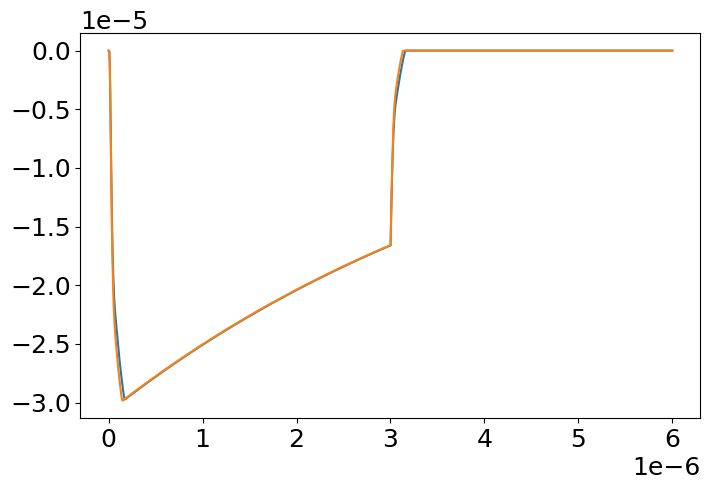

In [15]:
nesse.plot_signal(Events[0], show_plot=False)
nesse.plot_signal(Events[1], show_plot=False)
plt.show()

In [16]:
with np.printoptions(threshold=np.inf):
    print(Events[0].signal[0][4:])

[-2.18944060e-09 -1.85241668e-08 -6.03187671e-08 -1.30814617e-07
 -2.41792435e-07 -4.01835275e-07 -6.12371918e-07 -8.76999717e-07
 -1.19720207e-06 -1.57078396e-06 -1.99723286e-06 -2.47359984e-06
 -2.99450699e-06 -3.55515832e-06 -4.14903747e-06 -4.76810520e-06
 -5.40618691e-06 -6.05709312e-06 -6.71430337e-06 -7.37291808e-06
 -8.02767968e-06 -8.67451280e-06 -9.31068577e-06 -9.93337938e-06
 -1.05406981e-05 -1.11320626e-05 -1.17061557e-05 -1.22621361e-05
 -1.28005056e-05 -1.33204910e-05 -1.38212497e-05 -1.43028823e-05
 -1.47653969e-05 -1.52085807e-05 -1.56327555e-05 -1.60382505e-05
 -1.64250262e-05 -1.67935904e-05 -1.71448261e-05 -1.74789458e-05
 -1.77963176e-05 -1.80976658e-05 -1.83838094e-05 -1.86556017e-05
 -1.89140770e-05 -1.91600352e-05 -1.93945242e-05 -1.96182911e-05
 -1.98319190e-05 -2.00360257e-05 -2.02311843e-05 -2.04178467e-05
 -2.05963274e-05 -2.07669945e-05 -2.09301895e-05 -2.10860867e-05
 -2.12349352e-05 -2.13770838e-05 -2.15127085e-05 -2.16421653e-05
 -2.17659424e-05 -2.18843

We can also plot the induced current before the electronics

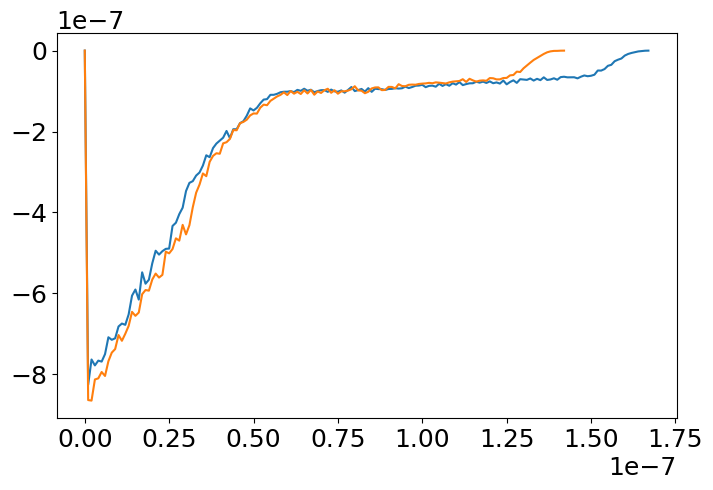

In [17]:
nesse.plot_current(Events[0], show_plot=False)
nesse.plot_current(Events[1], show_plot=False)
plt.show()

You can also plot the e-h drift paths. Plotting all pairs would take a long time, so I've plotted just the first 10 here. 

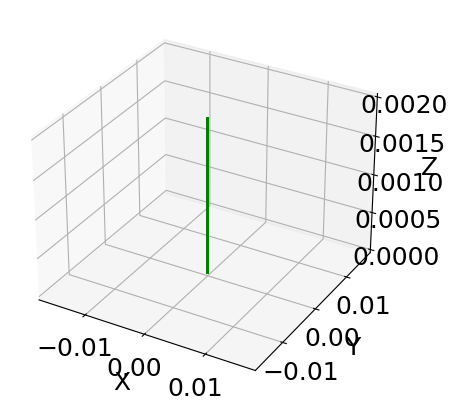

In [18]:
nesse.plot_event_drift(Events[0], bounds, pairs=10)

plotting for fields and potentials is included in nessie

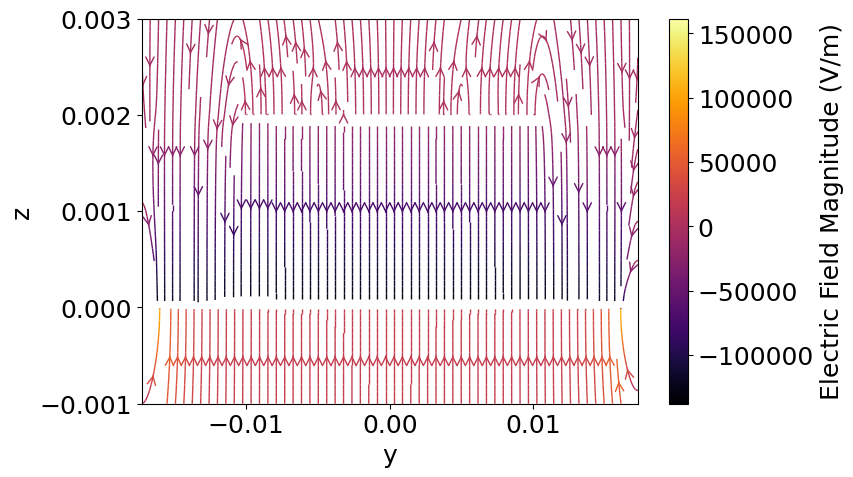

<Figure size 800x500 with 0 Axes>

In [19]:
nesse.plot_field_lines(sim.electricField,x_plane=True, density=2, show_plot=True, log=False)

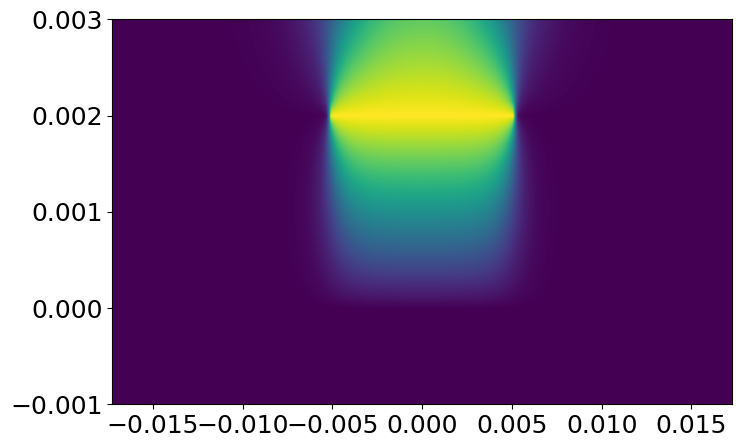

<Figure size 800x500 with 0 Axes>

In [22]:
nesse.plot_potential(sim.weightingPotential[0])

### nabPy Analysis
With the event downsampled we can now analyze it using nabPy.
Lets first zoom in on the rising edge.

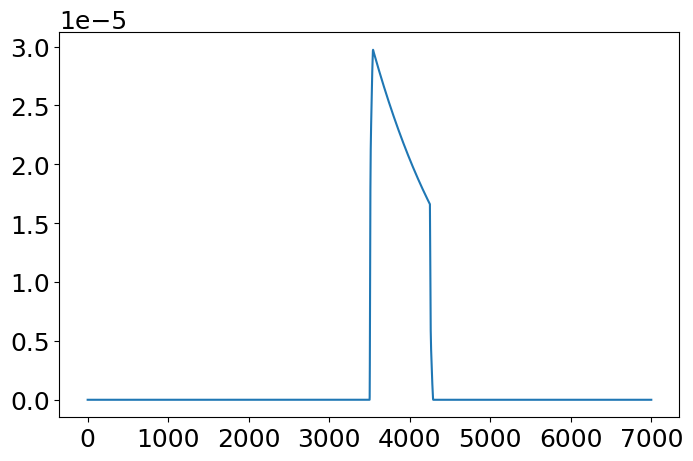

In [23]:
plt.plot(-nabPy_events[0])
# plt.xlim(3400,3600)
plt.show()

Since this is already a numpy array we can use nabPy analsysis functions out of the box. For example we can get the risetimes:

In [24]:
Nab.basicFunctions.extractRiseTimes(-nabPy_events,low=0.1,high=0.9)

array([27., 21.])

recall we used a 4ns time step so this corresponds to a 52 ns risetime, which is reasonable.

other nabPy analsysis functions work too

In [25]:
Nab.basicFunctions.extractDecayRate(-nabPy_events)

array([1259.9805, 1258.5398], dtype=float32)

In [26]:
Nab.basicFunctions.applyTrapFilter(-nabPy_events, 1250,50,1250)

(array([2.20190516e-05, 2.20284018e-05]), array([3347.5, 3346.5]))